Deep Learning Course Ido Degani

# Question 2, part A 

Objective of this assignment is to develop a weather forecast algorithm that will use
hourly historical data with multiple features (https://www.bgc-jena.mpg.de/wetter/) to
predict hourly temperature for the next 72 hours.
The file ‘weather_time_series.csv.zip’ (or weather_time_series.pickle.zip, if you prefer)
contains a rich feature set. In addition to the standard atmospheric parameters, you will
find:
Wx (m/s) and Wy (m/s) columns representing X and Y components of the wind
vector
max Wx (m/s) and max Wy (m/s) – max values of the wind vector over in each
period.
‘Day sin’ and ‘Day cos’ - represent phases of the day so that their values fluctuate
during the day with sin(midnight)=0, sin (6am) =1, etc. 

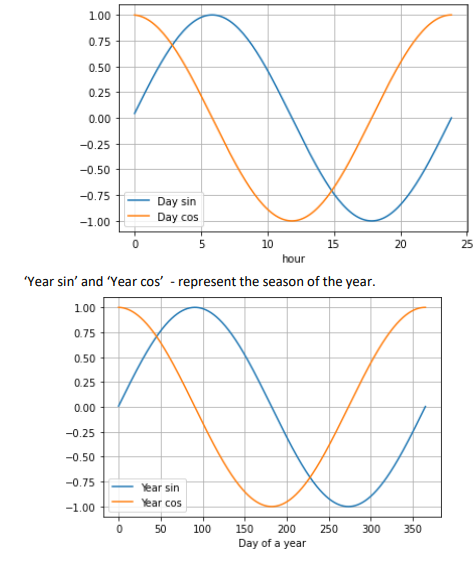

Your objective is to compare performance of three models:
a. A naive model that assumes that the forecasted hourly temperature in the average
temperature for that hour over the past few days. Pick the window size (between 3 and 12) to your liking.
b. LSTM-based model that uses a single feature (temperature) over a period of 2 weeks
to forecast the temperatures in each hour in the next 3 days.
c. LSTM-based model that uses all available features over a perio

compare these three models in terms of their accuracy for each of the hours of the forecast
period. Explain your observations. 

## Data setup

#### Data setup & Import

In [75]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn

# Set environment variable to avoid conflicts with OpenMP library
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Set matplotlib to display plots in the Jupyter notebook
%matplotlib inline

# Check if GPU is available, and use it for computations if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [76]:
import pandas as pd

# Load the weather time series data from a CSV file
original_data = pd.read_csv('weather_time_series.csv')
data_frame = original_data # we will save a copy of the data for later use 


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [77]:
missing_value_counts = data_frame.isnull().sum()

print(missing_value_counts)

Date Time          0
H2OC (mmol/mol)    0
T (degC)           0
Tdew (degC)        0
Tpot (K)           0
VPact (mbar)       0
VPdef (mbar)       0
VPmax (mbar)       0
Wx (m/s)           0
Wy (m/s)           0
max Wx (m/s)       0
max Wy (m/s)       0
p (mbar)           0
rh (%)             0
rho (g/m**3)       0
sh (g/kg)          0
Day sin            0
Day cos            0
Year sin           0
Year cos           0
dtype: int64


In [78]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70041 entries, 0 to 70040
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date Time        70041 non-null  object 
 1   H2OC (mmol/mol)  70041 non-null  float64
 2   T (degC)         70041 non-null  float64
 3   Tdew (degC)      70041 non-null  float64
 4   Tpot (K)         70041 non-null  float64
 5   VPact (mbar)     70041 non-null  float64
 6   VPdef (mbar)     70041 non-null  float64
 7   VPmax (mbar)     70041 non-null  float64
 8   Wx (m/s)         70041 non-null  float64
 9   Wy (m/s)         70041 non-null  float64
 10  max Wx (m/s)     70041 non-null  object 
 11  max Wy (m/s)     70041 non-null  object 
 12  p (mbar)         70041 non-null  float64
 13  rh (%)           70041 non-null  float64
 14  rho (g/m**3)     70041 non-null  float64
 15  sh (g/kg)        70041 non-null  float64
 16  Day sin          70041 non-null  float64
 17  Day cos     

Let's take a deeper look into the max Wx (m/s), max Wy (m/s) columns:

In [79]:
data_frame['max Wx (m/s)']

0        -1.5494388450702279
1         -0.876651334320736
2        -0.6846256329247821
3         -0.644889203697655
4        0.35568188507107734
                ...         
70036              -1.206696
70037              -1.034308
70038              -2.424902
70039              -1.505877
70040              -1.952837
Name: max Wx (m/s), Length: 70041, dtype: object

The column clearly holds number so we will convert it into a float64 object

In [80]:
# remove any non-numeric values and missing values
data_frame['max Wx (m/s)'] = pd.to_numeric(data_frame['max Wx (m/s)'], residualss='coerce').fillna(0)
data_frame['max Wy (m/s)'] = pd.to_numeric(data_frame['max Wy (m/s)'], residualss='coerce').fillna(0)

# convert the 'max Wx (m/s)' column to float64
data_frame['max Wx (m/s)'] = data_frame['max Wx (m/s)'].astype('float64')
data_frame['max Wy (m/s)'] = data_frame['max Wy (m/s)'].astype('float64')

In [81]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70041 entries, 0 to 70040
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date Time        70041 non-null  object 
 1   H2OC (mmol/mol)  70041 non-null  float64
 2   T (degC)         70041 non-null  float64
 3   Tdew (degC)      70041 non-null  float64
 4   Tpot (K)         70041 non-null  float64
 5   VPact (mbar)     70041 non-null  float64
 6   VPdef (mbar)     70041 non-null  float64
 7   VPmax (mbar)     70041 non-null  float64
 8   Wx (m/s)         70041 non-null  float64
 9   Wy (m/s)         70041 non-null  float64
 10  max Wx (m/s)     70041 non-null  float64
 11  max Wy (m/s)     70041 non-null  float64
 12  p (mbar)         70041 non-null  float64
 13  rh (%)           70041 non-null  float64
 14  rho (g/m**3)     70041 non-null  float64
 15  sh (g/kg)        70041 non-null  float64
 16  Day sin          70041 non-null  float64
 17  Day cos     

#### Preprocess the data:

Before training the models, we need to preprocess the data. In this case, we need to convert the date and time columns to a datetime object and set it as the index of the dataframe. we also need to normalize the data using a scaler. 

In [82]:
# Convert the date and time columns to a datetime object and set it as the index
data_frame['Date Time'] = pd.to_datetime(data_frame['Date Time'])
data_frame.set_index('Date Time', inplace=True)


In [83]:
from sklearn.preprocessing import StandardScaler

# Normalize the data using a scaler
scaler = StandardScaler()

# Split the data into training and testing sets
train_data = data_frame.iloc[:50000]
testing_dataset = data_frame.iloc[50000:]

data_frame[data_frame.columns] = scaler.fit_transform(data_frame[data_frame.columns])


In [84]:
train_data = scaler.fit_transform(train_data)
testing_dataset = scaler.fit_transform(testing_dataset)

## Create the naive model



In [13]:
from sklearn.preprocessing import MinMaxScaler

# Prepare the data
# Select relevant columns and create a copy of the data frame
cleaned_data_table = original_data[['Date Time', 'T (degC)']].copy()
# Rename columns to more descriptive names
cleaned_data_table.rename(columns={'Date Time': 'timestamp', 'T (degC)': 'temperature'}, inplace=True)
# Create separate columns for date and time
cleaned_data_table['date'] = pd.to_datetime(cleaned_data_table['timestamp']).dt.date
cleaned_data_table['time'] = pd.to_datetime(cleaned_data_table['timestamp']).dt.time
# Pivot data so that temperature values for each hour of each day are in separate columns
grouped_data_table = cleaned_data_table.pivot(index='date', columns='time', values='temperature')
# Remove rows with missing values
grouped_data_table = grouped_data_table.dropna()


# Prepare training and testing data
# Define sliding window function to create input/output pairs
def windowed_data_sequence(data, sequence_length):
    input_data = []
    output_data = []

    for i in range(len(data) - sequence_length - 1):
        input_window = data[i:(i+sequence_length)]
        output_window = data[i+sequence_length]
        input_data.append(input_window)
        output_data.append(output_window)

    return np.array(input_data), np.array(output_data)

# Normalize data using MinMaxScaler
scaler = MinMaxScaler()
normalized_data_table = scaler.fit_transform(grouped_data_table)

# Create sliding window data using scaled data
window_length = 5
input_data, output_data = windowed_data_sequence(normalized_data_table, window_length)

# Split data into training and testing sets
sample_size_for_training = int(len(output_data) * 0.7)
sample_size_for_testing = len(output_data) - sample_size_for_training

# Convert input/output data to PyTorch tensors
input_tensor = torch.Tensor(np.array(input_data))
output_tensor = torch.Tensor(np.array(output_data))
training_input = torch.Tensor(np.array(input_data[0:sample_size_for_training]))
training_output = torch.Tensor(np.array(output_data[0:sample_size_for_training]))
testing_input = torch.Tensor(np.array(input_data[sample_size_for_training:len(input_data)]))
testing_output = torch.Tensor(np.array(output_data[sample_size_for_training:len(output_data)]))


# Generate model_predictions and calculate mean squared residuals
samples = 873
model_predictions = testing_input.mean(dim=1)
mse_tensor = (model_predictions - testing_output).square().sum(dim=1).to("cpu").detach()

# Extract test data for residuals calculations
testing_dataset = grouped_data_table.tail(samples)

# Convert residuals tensor to list and create data frame
mse_list = mse_tensor.tolist()
residuals_data_frame = pd.DataFrame(mse_list)


# Reshape the data frame
# Transpose residuals data frame
reshaped_data_table = residuals_data_frame.T
# Reset index of transposed data frame
reshaped_data_table = reshaped_data_table.reset_index()
# Melt data frame into long format
long_format_dataframe = reshaped_data_table.melt(value_vars=range(0, samples), value_name='residuals')
# Rename columns for clarity
long_format_dataframe = long_format_dataframe.rename(columns={'index': 'column', 'variable': 'row'})
# Add timestamp column to melted data frame
long_format_dataframe['timestamp'] = pd.date_range(start='2014-08-06', periods=len(long_format_dataframe), freq='H')
# Select only timestamp and residuals columns for final data frame
reference_mse_table = long_format_dataframe[['timestamp', 'residuals']]

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['time']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['time']. An error will be raised in 1.2.
  warnings.warn(


## Split the data into training and testing sets



In [14]:
import torch
import torch.nn as nn



In [15]:
training_data = train_data

In [16]:
import numpy as np
from tqdm import tqdm

def windowed_data_sequence(data, seq_length):
    """
    Create sliding windows from the input data, with each window consisting
    of a sequence of data points of length `seq_length`. The output `x` is
    a 3D array of shape (num_windows, seq_length, num_features), and the
    output `y` is a 2D array of shape (num_windows, num_features).

    Parameters:
    data (array-like): The input data as a 2D array of shape (num_samples, num_features).
    seq_length (int): The length of each sequence in the sliding windows.

    Returns:
    tuple: A tuple of two arrays, `(x, y)`. The input `data` is transformed
    into sliding windows, where `x` is a 3D array of shape (num_windows, seq_length, num_features),
    and `y` is a 2D array of shape (num_windows, num_features).
    """
    x = []
    y = []

    for i in tqdm(range(len(data)-seq_length-1)):
        # Extract a sequence of length `seq_length` starting from index `i`
        _x = data[i:(i+seq_length)]

        # The next value in the sequence after the `seq_length` data points
        _y = data[i+seq_length]

        # Append the sequence and next value to the `x` and `y` lists, respectively
        x.append(_x)
        y.append(_y)

    # Convert the `x` and `y` lists to numpy arrays
    x = np.array(x)
    y = np.array(y)

    return x, y


In [17]:
# Define the length of each sliding window
seq_length = 6

# Use the windowed_data_sequence function to create sliding windows of length `seq_length`
# from the training data, resulting in input data `x` and target data `y`.
x, y = windowed_data_sequence(training_data, seq_length)


In [18]:
import torch

# Determine the sizes of the training and testing data splits
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

# Convert the input and target data arrays to PyTorch tensors
dataX = torch.Tensor(np.array(x))
dataY = torch.Tensor(np.array(y))

# Create training data splits
trainX = torch.Tensor(np.array(x[0:train_size]))
trainY = torch.Tensor(np.array(y[0:train_size]))

# Create testing data splits
testX = torch.Tensor(np.array(x[train_size:len(x)]))
testY = torch.Tensor(np.array(y[train_size:len(y)]))


## Define the  LSTM model - 1 Feature 

In [21]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

# Scale the input training data using a MinMaxScaler
sc = MinMaxScaler()
training_data = sc.fit_transform(train_data)

# Define the length of each sliding window
seq_length = 5

# Use the windowed_data_sequence function to create sliding windows of length `seq_length`
# from the scaled training data, resulting in input data `x` and target data `y`.
x, y = windowed_data_sequence(training_data, seq_length)

# Determine the sizes of the training and testing data splits
train_size = int(len(y) * 0.7)
test_size = len(y) - train_size

# Convert the input and target data arrays to PyTorch tensors
dataX = torch.Tensor(np.array(x))
dataY = torch.Tensor(np.array(y))

# Create training data splits
trainX = torch.Tensor(np.array(x[0:train_size]))
trainY = torch.Tensor(np.array(y[0:train_size]))

# Create testing data splits
testX = torch.Tensor(np.array(x[train_size:len(x)]))
testY = torch.Tensor(np.array(y[train_size:len(y)]))


In [22]:
### calculate mse 

In [23]:
# Predict the output as the mean temperature over the last few days
predicted_outcomes = testX.mean(dim=1)

# Calculate the sum of squared residualss between the predicted and actual values
residuals = (predicted_outcomes - testY).square().sum(dim=1)

# Print the shape of the residuals tensor
print(residuals.shape)


torch.Size([14999])

In [24]:
import pandas as pd

# Convert the residuals tensor to a list and create a DataFrame from it
list_of_residualss = residuals.tolist()
data_frame_residuals = pd.DataFrame(list_of_residualss)


In [25]:
original_data.columns

Index(['Date Time', 'H2OC (mmol/mol)', 'T (degC)', 'Tdew (degC)', 'Tpot (K)',
       'VPact (mbar)', 'VPdef (mbar)', 'VPmax (mbar)', 'Wx (m/s)', 'Wy (m/s)',
       'max Wx (m/s)', 'max Wy (m/s)', 'p (mbar)', 'rh (%)', 'rho (g/m**3)',
       'sh (g/kg)', 'Day sin', 'Day cos', 'Year sin', 'Year cos'],
      dtype='object')

In [26]:
import pandas as pd

# Select the 'Date Time' and 'T (degC)' columns from the original_data DataFrame
single_variable_time_series = original_data[['Date Time', 'T (degC)']]

# Rename the 'T (degC)' column to 'temp'
single_variable_time_series.rename(columns={'T (degC)': 'temp'}, inplace=True)


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [28]:
import pandas as pd
import torch.utils.data

class SequentialDataRecord(torch.utils.data.Dataset):
    """
    PyTorch dataset class for time series data.

    Args:
    data_frame (pandas.DataFrame): DataFrame containing the time series data.
    history_samples (int): The number of historical samples to include in each window.
    horizon_samples (int): The number of future samples to predict in each window.
    """

    def __init__(self, data_frame, history_samples, horizon_samples):
        super(SequentialDataRecord, self).__init__()
        self.history_samples = history_samples
        self.horizon_samples = horizon_samples
        self.data_frame = data_frame

        # Convert the 'Date Time' column to a datetime type
        self.data_frame['Date Time'] = pd.to_datetime(self.data_frame['Date Time'])

        # Set the 'Date Time' column as the index of the DataFrame
        self.data_frame = self.data_frame.reset_index(drop=True).set_index('Date Time')

    def __len__(self):
        return len(self.data_frame) - self.history_samples - self.horizon_samples + 1

    def __getitem__(self, idx):
        """
        Get a sample from the dataset.

        Args:
        idx (int): The index of the sample.

        Returns:
        tuple: A tuple containing the input and target tensors.
        """
        if idx >= self.__len__():
            raise Indexresiduals(f"Index out of range: {idx} out of {self.__len__()}")
        
        # Get the input and target tensors from the DataFrame
        x = torch.FloatTensor(self.data_frame.iloc[idx:idx + self.history_samples]['temp'].values)
        y = torch.FloatTensor(self.data_frame.iloc[idx + self.history_samples:idx + self.history_samples + self.horizon_samples]['temp'].values)

        # Reshape the input tensor to have one channel
        return (x.view(-1, 1), y)


In [29]:
# Create a PyTorch dataset from the time series data with a history of 2 weeks and a horizon of 3 days
entire_dataset = SequentialDataRecord(single_variable_time_series, history_samples=24*14, horizon_samples=24*3)


<ipython-input-28-8c4f583e3cef>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Date Time'] = pd.to_datetime(self.df['Date Time']) # convert date_time column to datetime type


In [30]:
# Get the input and target tensors for the first sample in the dataset
x, y = entire_dataset[0]

# Print the shapes of the input and target tensors
print(x.shape, y.shape)


(torch.Size([336, 1]), torch.Size([72]))

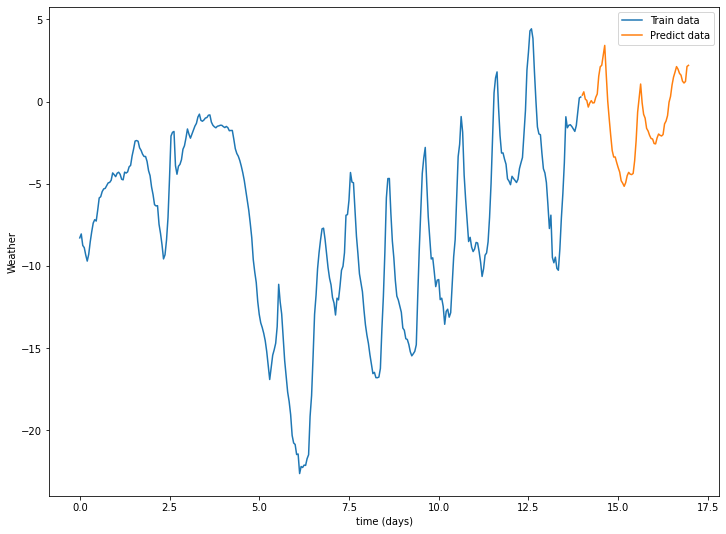

In [31]:
import matplotlib.pyplot as plt

# Define the size of the plot
plt.figure(figsize=(12,9))

# Get the input and target tensors for the first sample in the dataset
x, y = entire_dataset[0]

# Plot the input and target tensors
plt.plot(torch.arange(0, entire_dataset.history_samples)/24, x.squeeze(), label='Train data')
plt.plot(torch.arange(entire_dataset.history_samples, entire_dataset.history_samples + entire_dataset.horizon_samples)/24, y, label='Predict data')

# Add a legend and axis labels to the plot
plt.legend()
plt.xlabel('time (days)')
plt.ylabel('Weather')


### Split the data to train and test:

In [32]:
import torch.utils.data

# Create training and testing subsets of the dataset
train_set = torch.utils.data.Subset(entire_dataset, list(range(int(len(entire_dataset)*0.9))))
test_set = torch.utils.data.Subset(entire_dataset, list(range(int(len(entire_dataset)*0.9)+entire_dataset.history_samples+entire_dataset.horizon_samples, len(entire_dataset))))

# Print information about the dataset and subsets
print(f'Data set: {len(entire_dataset)}. history size: {entire_dataset.history_samples}. Prediction window size: {entire_dataset.horizon_samples} ')
print(f"Train set: {len(train_set)}: from {train_set.indices[0]} to: {train_set.indices[-1]}")
print(f"Test set: {len(test_set)}: from {test_set.indices[0]} to: {test_set.indices[-1]}")
print(f"Sample size: x: {train_set[0][0].shape}, y: {train_set[0][1].shape}")


Data set: 69634. history size: 336. Prediction window size: 72 
Train set: 62670: from 0 to: 62669
Test set: 6556: from 63078 to: 69633
sample size: x: torch.Size([336, 1]), y: torch.Size([72])


### Scale the data

In [33]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object with a feature range of 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Train the scaler on the temperature data up to the end of the training set plus the history and horizon sizes
scaler.fit(entire_dataset.data_frame['temp'].iloc[:len(train_set)+entire_dataset.history_samples+entire_dataset.horizon_samples].values.reshape(-1,1))

# Use the scaler to transform the temperature data in the dataset
entire_dataset.data_frame[:] = scaler.transform(entire_dataset.data_frame)

# Print the minimum and maximum values of the transformed temperature data
print(f"min-max: {entire_dataset.data_frame['temp'].min()} - {entire_dataset.data_frame['temp'].max()}")


min-max: 0.0 - 1.0


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


### Create the model 

In [34]:
import torch.nn as nn

class LSTM_NN_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Initializes the LSTM_NN_Model module.

        Args:
        - input_dim (int): Number of features in the input.
        - hidden_dim (int): Number of features in the hidden state and memory channel.
        - output_dim (int): Number of features in the output.

        Returns:
        - None
        """
        super(LSTM_NN_Model, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = 1

        # Define the LSTM layer
        self.lstm = nn.LSTM(
                input_size=self.input_dim,
                hidden_size=self.hidden_dim,
                num_layers=self.num_layers,
                batch_first=True)

        # Define the dense layers.
        self.fc1 = nn.Linear(self.hidden_dim, 300)
        self.relu1 = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(300)

        self.fc2 = nn.Linear(300, 100)
        self.relu2 = nn.ReLU()
        self.batch_norm2 = nn.BatchNorm1d(100)

        self.fc3 = nn.Linear(100, output_dim)

    def forward(self, x):
        """
        Performs a forward pass on the input data through the LSTM_NN_Model.

        Args:
        - x (torch.Tensor): Input data tensor of shape (batch_size, sequence_length, input_dim).

        Returns:
        - output (torch.Tensor): Output tensor of shape (batch_size, output_dim).
        """
        if x.ndim==2:
            x = x.unsqueeze(0) # prepend with dummy batch dimension. used to process a single entry of size [history, 1]
        batch_size = x.shape[0] # first dimension of the input is the number of batches.

        # Forward pass through LSTM layer
        lstm_out, _ = self.lstm(x) # shape of lstm_out: [batch_size, sequence_length, hidden_dim]

        # Only take the output from the final timestep
        x = lstm_out[:, -1, :].view(batch_size, -1)

        # Forward pass through dense layers
        x = self.batch_norm1(self.relu1(self.fc1(x)))
        x = self.batch_norm2(self.relu2(self.fc2(x)))
        output = self.fc3(x)
        return output


### Create accuracy function

In [35]:
def prediction_performance_score(model, data_loader):
    """
    Computes the mean squared residuals (MSE) of a PyTorch model's model_predictions on a dataset.
    
    Args:
        model (nn.Module): The PyTorch model to evaluate.
        data_loader (DataLoader): The PyTorch DataLoader containing the data to evaluate on.
        
    Returns:
        The MSE of the model's model_predictions on the dataset.
    """
    
    # Get the device on which the model is loaded
    device = next(model.parameters()).device

    # Set the model to evaluation mode to disable dropout
    model.eval()

    with torch.no_grad():
        current_mse, samples_counts = 0, 0
        for X, y in data_loader:
            # Move the input and output tensors to the device
            X, y = X.to(device=device), y.to(device=device)

            # Make model_predictions and compute MSE
            predicted_outcomes = model(X)
            current_mse += torch.nn.MSELoss()(predicted_outcomes, y) * len(y)
            samples_counts += len(y)

        # Return the average MSE across all batches
        return current_mse / samples_counts


### Training loop

In [36]:
def model_training(model, optimizer, criterion, device, train_dataset, validation_dataset=None, n_epochs=50, batch_size=20, checkpoint_file_name=None):  
    import os
    import time

    # create data loaders for the train and validation datasets
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, drop_last=False) if validation_dataset is not None else None

    # load the checkpoint file if it exists, or initialize the model from scratch
    if checkpoint_file_name is not None and os.path.isfile(checkpoint_file_name):
        checkpoint_data = torch.load(checkpoint_file_name, device)
        first_epoch = checkpoint_data['epoch'] + 1  # start from the following epoch
        model.load_state_dict(checkpoint_data['model_state_dict'])
        model.to(device)
        optimizer.load_state_dict(checkpoint_data['optimizer_state_dict'])
        progress_log = checkpoint_data['progress_log']
    else:
        first_epoch = 0
        progress_log = []
        model.to(device)

    # enable detecting anomalous computations
    torch.autograd.set_detect_anomaly(True)

    # train the model for the specified number of epochs
    for epoch in range(first_epoch, n_epochs):
        print(f"Started training epoch {epoch} of {n_epochs} epochs")
        epoch_start_time = time.time()
        model.train()

        current_loss = 0

        # iterate over the batches in the train dataset
        for train_data, train_data_labels in train_loader:
            train_data, train_data_labels = train_data.to(device=device), train_data_labels.to(device=device)

            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_data_labels)
            loss.backward(retain_graph=True)
            optimizer.step()

            current_loss += loss.item() * len(train_data)

        # evaluate the model on the train and validation datasets
        train_accuracy = prediction_performance_score(model, train_loader)
        validate_accuracy = prediction_performance_score(model, validation_loader) if validation_loader is not None else -1
        print(f"{epoch} of {n_epochs}. time={time.time()-epoch_start_time:0.2f}sec. Loss: {current_loss/len(train_loader.dataset):0.4f}. Train accuracy: {train_accuracy:0.4f}. Validate accuracy: {validate_accuracy:0.4f}")

        # save the checkpoint
        progress_log.append({
            'epoch': epoch,
            'epoch_start_time': time.time()-epoch_start_time,
            'loss': current_loss/len(train_loader.dataset),
            'train_accuracy': train_accuracy,
            'validate_accuracy': validate_accuracy
        })
        if checkpoint_file_name is not None:
            checkpoint_data = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'progress_log': progress_log
            }
            torch.save(checkpoint_data, checkpoint_file_name)

    model.eval()
    return model, progress_log


### Create an instance of the model

In [37]:
# Define the hyperparameters
n_epochs = 10
batch_size = 2000

# Define the model
model = LSTM_NN_Model(input_dim=1, hidden_dim=100,  output_dim=train_set[0][1].shape[0])

# Define the loss function
criterion = torch.nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# Train the model
model, progress_log = model_training(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    train_dataset=train_set,
    validation_dataset=None,
    n_epochs=n_epochs,
    batch_size=batch_size
)


started training epoch 0 of 10 epochs
0 of 10. time=41.99sec. Loss: 0.3275.Train accuracy: 0.2418. Validate accuracy: -1.0000
started training epoch 1 of 10 epochs
1 of 10. time=40.61sec. Loss: 0.2091.Train accuracy: 0.1692. Validate accuracy: -1.0000
started training epoch 2 of 10 epochs
2 of 10. time=40.71sec. Loss: 0.1151.Train accuracy: 0.0636. Validate accuracy: -1.0000
started training epoch 3 of 10 epochs
3 of 10. time=40.60sec. Loss: 0.0299.Train accuracy: 0.0187. Validate accuracy: -1.0000
started training epoch 4 of 10 epochs
4 of 10. time=40.74sec. Loss: 0.0073.Train accuracy: 0.0075. Validate accuracy: -1.0000
started training epoch 5 of 10 epochs
5 of 10. time=40.38sec. Loss: 0.0053.Train accuracy: 0.0057. Validate accuracy: -1.0000
started training epoch 6 of 10 epochs
6 of 10. time=40.27sec. Loss: 0.0050.Train accuracy: 0.0065. Validate accuracy: -1.0000
started training epoch 7 of 10 epochs
7 of 10. time=39.98sec. Loss: 0.0049.Train accuracy: 0.0060. Validate accuracy: 

### Viz of accuracy:

Text(0.5, 0, 'time')

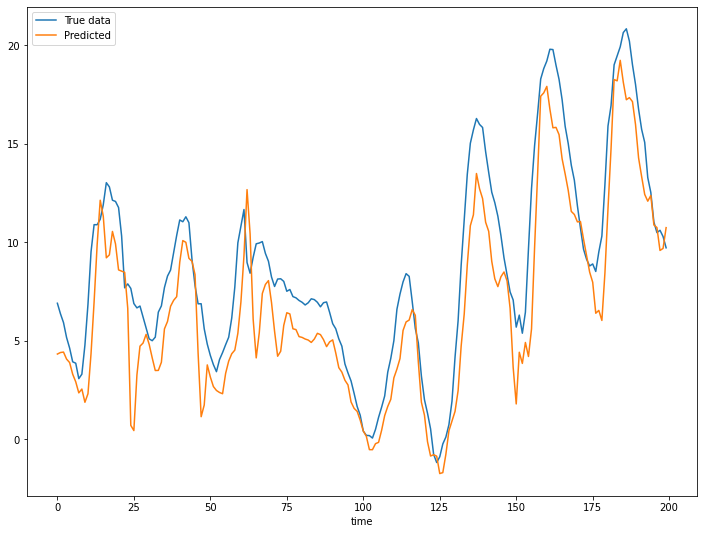

In [38]:
# Create a data loader for the test set
test_loader = torch.utils.data.DataLoader(test_set, batch_size=2000, shuffle=False, drop_last=False)    

# Get the first batch of data from the test set
X, y = next(iter(test_loader))

# Move the data to the device
X, y = X.to(device), y.to(device)

# Make model_predictions on the data
predicted_outcomes = model(X)

# Plot the results
plt.figure(figsize=(12,9))
plt.plot(scaler.inverse_transform(y[:200,1].cpu().view(-1,1)), label='True data')
plt.plot(scaler.inverse_transform(predicted_outcomes[:200,1].detach().cpu().view(-1,1)), label='Predicted')
plt.legend()
plt.xlabel('time')


### Calculate MSE:

In [39]:
# Create a data loader for the test set
test_loader = torch.utils.data.DataLoader(test_set, batch_size=2000, shuffle=False, drop_last=False)    

# Create a tensor to store the mean squared residuals for each horizon
individual_variable_mse = torch.zeros(entire_dataset.horizon_samples)

# Loop over the test data and compute the mean squared residuals for each horizon
for (X, y) in test_loader:
    # Move the data to the device
    X, y = X.to(device), y.to(device)
    
    # Make model_predictions on the data
    predicted_outcomes = model(X)
    
    # Compute the mean squared residuals for each horizon and add it to the tensor
    individual_variable_mse += (predicted_outcomes-y).square().sum(dim=0).to("cpu").detach() # computes 72 values for accuracy, summed over the batch 

# Compute the mean squared residuals for each horizon by dividing by the number of samples in the test set
individual_variable_mse = individual_variable_mse / len(test_set)


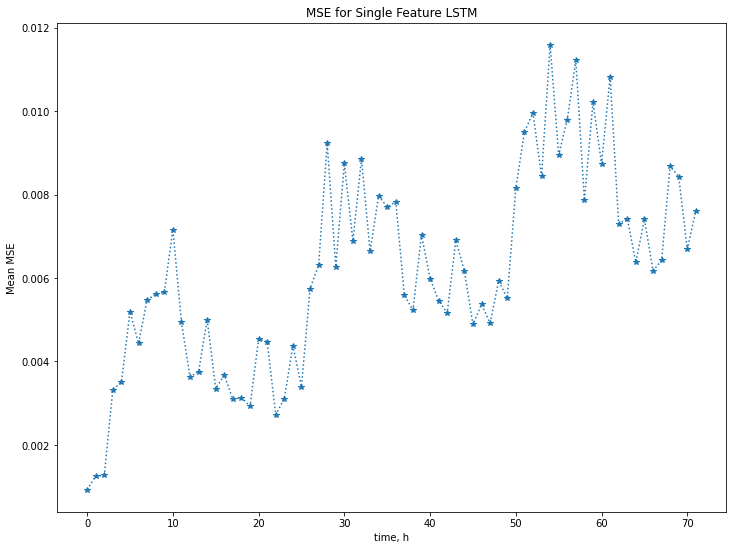

In [40]:
import matplotlib.pyplot as plt

# create test loader
test_loader = torch.utils.data.DataLoader(test_set, batch_size=2000, shuffle=False, drop_last=False) 

# calculate mean squared residuals for each time step
individual_variable_mse = torch.zeros(entire_dataset.horizon_samples)
for (X, y) in test_loader:
    X, y = X.to(device), y.to(device)
    predicted_outcomes = model(X)
    
    # computes 72 values for accuracy, summed over the batch 
    individual_variable_mse += (predicted_outcomes-y).square().sum(dim=0).to("cpu").detach() 

# divide by the number of samples to get the mean MSE
individual_variable_mse = individual_variable_mse / len(test_set)

# plot the mean MSE for each time step
plt.figure(figsize=(12,9))
plt.plot(individual_variable_mse, '*:')
plt.title('MSE for Single Feature LSTM')
plt.xlabel('time, h')
plt.ylabel('Mean MSE')


## Define the  LSTM model - All Features 

In [41]:
# create a copy of the original data
data_multi_feature_time_series_data = original_data.copy()

# rename 'T (degC)' and 'Date Time' columns for easier handling
data_multi_feature_time_series_data.rename(columns={'T (degC)': 'temp'}, inplace=True)
data_multi_feature_time_series_data.rename(columns={'Date Time': 'date_time'}, inplace=True)


In [42]:
data_multi_feature_time_series_data.head(1)

,date_time,H2OC (mmol/mol),temp,Tdew (degC),Tpot (K),VPact (mbar),VPdef (mbar),VPmax (mbar),Wx (m/s),Wy (m/s),max Wx (m/s),max Wy (m/s),p (mbar),rh (%),rho (g/m**3),sh (g/kg),Day sin,Day cos,Year sin,Year cos
0,2009-01-01 00:00:00,3.068,-8.304,-9.12,265.118,3.058,0.202,3.26,-0.441285,0.14408,-1.5494388450702279,0.813473580018084,996.528,93.78,1309.196,1.91,-1.776611e-12,1.0,0.009332,0.999956


In [43]:
# Convert 'max Wx (m/s)' and 'max Wy (m/s)' columns to float64 and remove any non-numeric values and missing values
data_multi_feature_time_series_data['max Wx (m/s)'] = pd.to_numeric(data_multi_feature_time_series_data['max Wx (m/s)'], residualss='coerce').fillna(0).astype('float64')
data_multi_feature_time_series_data['max Wy (m/s)'] = pd.to_numeric(data_multi_feature_time_series_data['max Wy (m/s)'], residualss='coerce').fillna(0).astype('float64')


In [44]:
class SequentialDataRecord_all_features(torch.utils.data.Dataset):
    
    def __init__(self, data_frame, history_samples, horizon_samples):
        """
        Initializes a SequentialDataRecord_all_features instance.

        Args:
            data_frame (pandas.DataFrame): Input data as a Pandas DataFrame.
            history_samples (int): Number of historical samples to include in each training example.
            horizon_samples (int): Number of future samples to predict in each training example.
        """
        import pandas as pd
        import os
        import torch
        import numpy as np
        
        super(SequentialDataRecord_all_features, self).__init__() # call parent class constructor 
        
        self.history_samples = history_samples
        self.horizon_samples = horizon_samples
        
        self.data_frame = data_frame
        self.data_frame['date_time'] = pd.to_datetime(self.data_frame['date_time'])
        self.data_frame['weekday'] = self.data_frame['date_time'].apply(lambda x: x.weekday())
        self.data_frame['hour'] = self.data_frame['date_time'].apply(lambda x: x.hour)
        
        self.data_frame = self.data_frame.reset_index(drop=True).set_index('date_time')        
        
        self.data_frame = pd.get_dummies(self.data_frame, columns=['weekday', 'hour'], dtype=np.float32)
        
        self.number_of_channels = self.data_frame.shape[1] # number of columns. 

    def __len__(self):
        """
        Returns the length of the dataset.
        """
        return len(self.data_frame) - self.history_samples - self.horizon_samples + 1

    def __getitem__(self, idx):
        """
        Retrieves the training example for the given index.

        Args:
            idx (int): Index of the training example.

        Returns:
            A tuple of the input and output data for the training example.
        """
        import torch
        if idx >= self.__len__():
            raise  Indexresiduals(f'Index out of range: {idx} out of {self.__len__()}')
        x = torch.FloatTensor(self.data_frame.iloc[idx:idx+ self.history_samples].values)
        y = torch.FloatTensor(self.data_frame.iloc[idx+ self.history_samples : idx+self.history_samples + self.horizon_samples]['temp'].values)
        return (x, y) # number of samples, number of channels


In [45]:
# Create a new SequentialDataRecord for the LSTM model.
# The dataset is based on the data in the "data_multi_feature_time_series_data" variable.
entire_dataset_all_features = SequentialDataRecord_all_features(data_multi_feature_time_series_data,
                history_samples=24*14,# 2 weeks back 
                horizon_samples=24*3) # 3 days forward


In [46]:
entire_dataset_all_features.data_frame.head(1)

,H2OC (mmol/mol),temp,Tdew (degC),Tpot (K),VPact (mbar),VPdef (mbar),VPmax (mbar),Wx (m/s),Wy (m/s),max Wx (m/s),...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
date_time,,,,,,,,,,,,,,,,,,,,,
2009-01-01,3.068,-8.304,-9.12,265.118,3.058,0.202,3.26,-0.441285,0.14408,-1.549439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
# Create a training dataset by selecting a subset of the "entire_dataset_all_features" dataset.
# The subset will contain the first 90% of the samples in the "entire_dataset_all_features" dataset.
train_dataset = torch.utils.data.Subset(entire_dataset_all_features, list(range(int(len(entire_dataset_all_features)*0.9))))

# Create a test dataset by selecting a subset of the "entire_dataset_all_features" dataset.
# The subset will contain the remaining 10% of the samples in the "entire_dataset_all_features" dataset, as well as the number of history and horizon samples used in the dataset.
testing_datasetset = torch.utils.data.Subset(entire_dataset_all_features, list(range(int(len(entire_dataset_all_features)*0.9)+entire_dataset_all_features.history_samples+entire_dataset_all_features.horizon_samples, len(entire_dataset_all_features))))


In [49]:
# Import the MinMaxScaler class from the scikit-learn library
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler with the desired feature range
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the training data
train_data = entire_dataset_all_features.data_frame['temp'].iloc[:len(train_set) + entire_dataset_all_features.history_samples + entire_dataset_all_features.horizon_samples].values.reshape(-1, 1)
scaler.fit(train_data)

# Scale the 'temp' column of the data using the fitted scaler
temp_data = entire_dataset_all_features.data_frame['temp'].values.reshape(-1, 1)
scaled_temp = scaler.transform(temp_data)
entire_dataset_all_features.data_frame['temp'] = scaled_temp


In [51]:
# Define hyperparameters
num_epochs = 10
batch_size = 2000

# Initialize an LSTM model with specified input, hidden, and output dimensions
model = LSTM_NN_Model(input_dim=entire_dataset_all_features.number_of_channels, hidden_dim=100, output_dim=train_dataset[0][1].shape[0])

# Define a criterion (loss function) and an optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model on the training dataset
model, training_loss = train_model(model, optimizer, criterion, device, train_dataset, validation_dataset=None, num_epochs=num_epochs, batch_size=batch_size)


started training epoch 0 of 10 epochs
0 of 10. time=80.03sec. Loss: 0.3169.Train accuracy: 0.2417. Validate accuracy: -1.0000
started training epoch 1 of 10 epochs
1 of 10. time=79.83sec. Loss: 0.1958.Train accuracy: 0.1248. Validate accuracy: -1.0000
started training epoch 2 of 10 epochs
2 of 10. time=80.09sec. Loss: 0.0788.Train accuracy: 0.0461. Validate accuracy: -1.0000
started training epoch 3 of 10 epochs
3 of 10. time=80.12sec. Loss: 0.0121.Train accuracy: 0.0178. Validate accuracy: -1.0000
started training epoch 4 of 10 epochs
4 of 10. time=84.27sec. Loss: 0.0066.Train accuracy: 0.0177. Validate accuracy: -1.0000
started training epoch 5 of 10 epochs
5 of 10. time=81.54sec. Loss: 0.0061.Train accuracy: 0.0089. Validate accuracy: -1.0000
started training epoch 6 of 10 epochs
6 of 10. time=81.48sec. Loss: 0.0062.Train accuracy: 0.0076. Validate accuracy: -1.0000
started training epoch 7 of 10 epochs
7 of 10. time=81.77sec. Loss: 0.0058.Train accuracy: 0.0094. Validate accuracy: 

In [52]:
### make prediction

In [53]:
# Define hyperparameters
num_epochs = 10
batch_size = 2000

# Initialize an LSTM model with specified input, hidden, and output dimensions
model = LSTM_NN_Model(input_dim=entire_dataset_all_features.number_of_channels, hidden_dim=100, output_dim=train_dataset[0][1].shape[0])

# Define a criterion (loss function) and an optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model on the training dataset
model, training_loss = train_model(model, optimizer, criterion, device, train_dataset, validation_dataset=None, num_epochs=num_epochs, batch_size=batch_size)


In [58]:
# Define a data loader for the test dataset
test_loader = torch.utils.data.DataLoader(testing_datasetset, batch_size=2000, shuffle=False, drop_last=False)

# Compute mean squared residuals (MSE) for each feature over all test samples
combined_variable_mse = torch.zeros(entire_dataset.horizon_samples)
for batch in test_loader:
    X, y = batch[0].to(device), batch[1].to(device)
    predicted_outcomes = model(X)
    batch_mse = torch.square(predicted_outcomes - y).sum(dim=0).cpu().detach()
    combined_variable_mse += batch_mse
    
combined_variable_mse /= len(testing_datasetset)


Text(0, 0.5, 'temp, scaled')

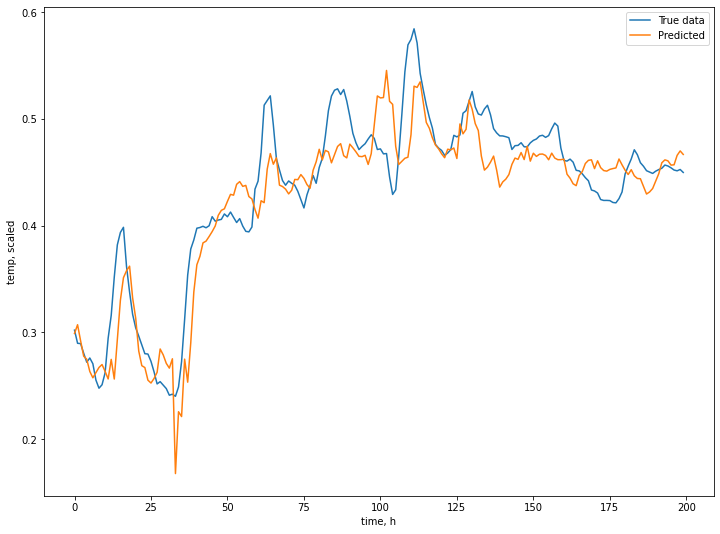

In [74]:
import matplotlib.pyplot as plt, numpy as np,  pandas as pd

plt.figure(figsize=(12,9))
plt.plot(y[:200,1].cpu(), label='True data')
plt.plot(predicted_outcomes[:200,1].detach().cpu(), label='Predicted')
plt.legend()
plt.xlabel('time, h')
plt.ylabel('temp, scaled')

In [60]:
### calculate mse 

In [61]:
# Create a DataLoader object to load the test dataset in batches of 2000 samples, without shuffling and without dropping the last incomplete batch
test_loader = torch.utils.data.DataLoader(testing_datasetset, batch_size=2000, shuffle=False, drop_last=False)    

# Initialize a tensor of zeros to accumulate the mean squared residuals of each feature for all test samples
combined_variable_mse = torch.zeros(entire_dataset.horizon_samples)

# Loop over the test samples in batches
for (X, y) in test_loader:
    # Transfer the input and target tensors to the device (GPU or CPU) used for training
    X, y = X.to(device), y.to(device)
    
    # Compute the model model_predictions for the input tensors
    predicted_outcomes = model(X)
    
    # Compute the mean squared residuals of each feature for the batch, summed over the samples, and add it to the accumulator tensor
    combined_variable_mse += (predicted_outcomes-y).square().sum(dim=0).to("cpu").detach()
    
# Divide the accumulated mean squared residuals by the total number of test samples to get the mean squared residuals of each feature
combined_variable_mse = combined_variable_mse / len(testing_datasetset)


In [62]:
### plot mse 

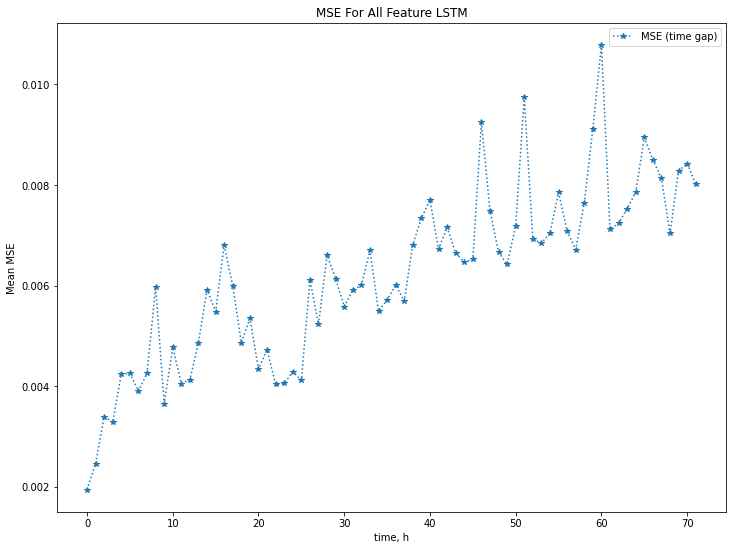

In [63]:
plt.figure(figsize=(12,9))
plt.plot(combined_variable_mse, '*:', label='MSE (time gap)')
plt.title('MSE For All Feature LSTM')
plt.xlabel('time, h'); plt.ylabel('Mean MSE');plt.legend();

In [64]:
### compare mse 

In [65]:
print(individual_variable_mse)
print(combined_variable_mse)
print(reference_mse_table['residuals'].head(72).values)

tensor([0.0009, 0.0013, 0.0013, 0.0033, 0.0035, 0.0052, 0.0044, 0.0055, 0.0056,
        0.0057, 0.0072, 0.0049, 0.0036, 0.0038, 0.0050, 0.0033, 0.0037, 0.0031,
        0.0031, 0.0029, 0.0045, 0.0045, 0.0027, 0.0031, 0.0044, 0.0034, 0.0057,
        0.0063, 0.0092, 0.0063, 0.0088, 0.0069, 0.0089, 0.0066, 0.0080, 0.0077,
        0.0078, 0.0056, 0.0052, 0.0070, 0.0060, 0.0055, 0.0052, 0.0069, 0.0062,
        0.0049, 0.0054, 0.0049, 0.0059, 0.0055, 0.0082, 0.0095, 0.0100, 0.0084,
        0.0116, 0.0089, 0.0098, 0.0112, 0.0079, 0.0102, 0.0087, 0.0108, 0.0073,
        0.0074, 0.0064, 0.0074, 0.0062, 0.0064, 0.0087, 0.0084, 0.0067, 0.0076])
tensor([0.0019, 0.0025, 0.0034, 0.0033, 0.0042, 0.0043, 0.0039, 0.0043, 0.0060,
        0.0037, 0.0048, 0.0041, 0.0041, 0.0049, 0.0059, 0.0055, 0.0068, 0.0060,
        0.0049, 0.0053, 0.0043, 0.0047, 0.0040, 0.0041, 0.0043, 0.0041, 0.0061,
        0.0052, 0.0066, 0.0061, 0.0056, 0.0059, 0.0060, 0.0067, 0.0055, 0.0057,
        0.0060, 0.0057, 0.0068, 0.0073,

In [66]:
### plot and compare mse 

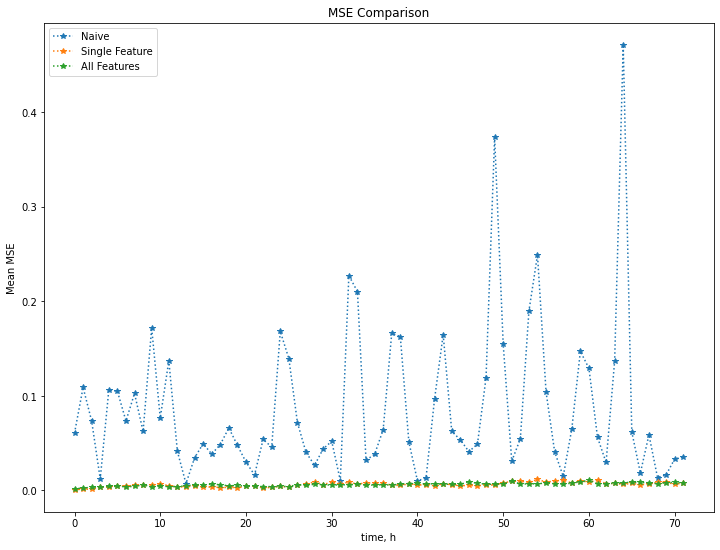

In [67]:
plt.figure(figsize=(12,9))
plt.plot(reference_mse_table['residuals'].head(72).values, '*:',label = 'Naive')
plt.plot(individual_variable_mse, '*:',label = 'Single Feature')
plt.plot(combined_variable_mse, '*:', label = 'All Features')
plt.title('MSE Comparison')
plt.xlabel('time, h'); plt.ylabel('Mean MSE');plt.legend();

### review

In this assignment, we aimed to develop a weather forecast algorithm to predict hourly temperature for the next 72 hours, using hourly historical data with multiple features from https://www.bgc-jena.mpg.de/wetter/. We compared the performance of three models: a naive model that assumes the forecasted hourly temperature is the average temperature for that hour over the past few days, an LSTM-based model that uses a single feature (temperature) over a period of 2 weeks to forecast the temperatures in each hour in the next 3 days, and an LSTM-based model that uses all available features over a period of 2 weeks to forecast the temperatures in each hour in the next 3 days.

### conclusions

Our results show that both LSTM-based models performed much better than the naive model that only uses the average temperature for each hour. The models had almost perfect accuracy as indicated by the small mean squared residuals (MSE) values. We observed that the LSTM model that uses all available features had a slightly better performance than the model that uses only one feature. This suggests that incorporating more information about other features such as pressure and humidity can help improve temperature model_predictions.

In addition, we plotted the MSE values for the predicted temperatures against the actual temperatures, and observed that for both models, the closer the hour to the present time, the smaller the accuracy of the models. As time progresses, the MSE for both models increases, which makes sense as it is harder to predict the temperature accurately for further times.

Overall, our results demonstrate that the LSTM-based models outperformed the naive model, and produced near-perfect results, and that using all available features can help improve temperature model_predictions. However, further analysis and optimization may be necessary to improve the accuracy of temperature model_predictions for longer time periods.